# **Dados PProductions - Análise e Estudo de Caso 📊📽️**
### Processo Seletivo Lighthouse - Indicium
#### Cauã Braga de Lima
---

In [ ]:
!python --version

Python 3.12.11


In [1]:
#importação das bibliotecas necessárias:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from wordcloud import WordCloud
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
import re
import pickle
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


Para o presente projeto será utilizada a metodologia CRISP-DM para padronizar a definição de objetivos e estabelecer, de forma clara, as análises de negócio necessárias para a resolução do problema. Nesse contexto, os dados a serem analisados correspondem ao banco de dados dos Estúdios PProductions.

#**1. ENTENDIMENTO DO NEGÓCIO**

Perguntas-chave do cliente (Empresa PProductions):
* Qual filme recomendar para uma pessoa desconhecida?
* Quais os principais fatores relacionados com alta
expectativa de faturamento de um filme?
* É possível inferir o gênero de um filme a partir de sua sinopse?
* É possível prever a nota do IMDB a partir dos dados?

Hipóteses da empresa (Indicium):
<br>
Os estúdios PProductions preferem uma previsão da nota do IMDB antes ou após o lançamento do filme? Caso seja antes, o faturamento e o número de votos do filme ainda não serão conhecidos, portanto, não serão levados em consideração para a modelagem. Nesse projeto, ambos os cenários serão abordados e terão seus resultados comparados.

Objetivos:
* Construir um modelo de regressão capaz de prever a nota do IMDB de um filme antes do seu lançamento (número de votos e faturamento desconhecidos) a partir dos dados fornecidos.
* Construir um modelo de regressão capaz de prever a nota do IMDB de um filme após o seu lançamento (número de votos e faturamento conhecidos) a partir dos dados fornecidos.
* Comparar os resultados de cada regressor e analisar a relevância de cada um.
* Identificar os fatores chave relacionados com a alta expectativa de faturamento de um filme.


# **2. ENTENDIMENTO DOS DADOS**

In [2]:
#carregamento dos dados:
import gdown
id_arquivo = '1GEgIJLGPibv6b6WW05UIluD6JcO6ZEoY'
url = f'https://drive.google.com/uc?export=download&id={id_arquivo}'
arquivo = 'desafio_indicium_imdb.csv'
gdown.download(url, arquivo, quiet=False)

#criação do DataFrame e remoção da coluna de índices:
df = pd.read_csv(arquivo).loc[:, ~pd.read_csv(arquivo).columns.str.contains('^Unnamed')]

Downloading...
From: https://drive.google.com/uc?export=download&id=1GEgIJLGPibv6b6WW05UIluD6JcO6ZEoY
To: /content/desafio_indicium_imdb.csv
100%|██████████| 303k/303k [00:00<00:00, 70.8MB/s]


In [3]:
#visualização dos dados:
df.head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


**Colunas Identificadas:**
* Series_Title -> Nome do filme
* Released_Year -> Ano de lançamento
* Certificate -> Classificação indicativa
* Runtime -> Duração
* Genre -> Gênero
* IMDB_Rating -> Taxa da Nota IMDB
* Overview -> Sinopse
* Metascore -> Metacrítica
* Director -> Diretor
* Star1 -> Estrela 1
* Star2 -> Estrela 2
* Star3 -> Estrela 3
* Star4 -> Estrela 4
* No_of_Votes -> N° de votos
* Gross -> Renda bruta


In [4]:
#verificação dos tipos de dados:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   999 non-null    object 
 1   Released_Year  999 non-null    object 
 2   Certificate    898 non-null    object 
 3   Runtime        999 non-null    object 
 4   Genre          999 non-null    object 
 5   IMDB_Rating    999 non-null    float64
 6   Overview       999 non-null    object 
 7   Meta_score     842 non-null    float64
 8   Director       999 non-null    object 
 9   Star1          999 non-null    object 
 10  Star2          999 non-null    object 
 11  Star3          999 non-null    object 
 12  Star4          999 non-null    object 
 13  No_of_Votes    999 non-null    int64  
 14  Gross          830 non-null    object 
dtypes: float64(2), int64(1), object(12)
memory usage: 117.2+ KB


Percebe-se que a base de dados possui apenas 3 colunas de tipos numéricos: "IMDB_Rating", "Meta_score" e "No_of_Votes".

In [5]:
#estatísticas descritivas das colunas numéricas:
df.describe()

,IMDB_Rating,Meta_score,No_of_Votes
count,999.000000,842.000000,9.990000e+02
mean,7.947948,77.969121,2.716214e+05
std,0.272290,12.383257,3.209126e+05
min,7.600000,28.000000,2.508800e+04
25%,7.700000,70.000000,5.547150e+04
50%,7.900000,79.000000,1.383560e+05
75%,8.100000,87.000000,3.731675e+05
max,9.200000,100.000000,2.303232e+06


Pela contagem de amostras, percebe-se que há valores ausentes na coluna "Meta_score". Além disso, as notas do IMDB variam em média por volta de 7.94 em que o filme mais bem avaliado tem nota IMDB 9.2 e o menos bem avaliado tem nota 7.6.

In [6]:
#verificando valores ausentes:
df.isnull().sum()

,0
Series_Title,0
Released_Year,0
Certificate,101
Runtime,0
Genre,0
IMDB_Rating,0
Overview,0
Meta_score,157
Director,0
Star1,0


As colunas "Certificate", "Meta_score" e "Gross" possuem valores ausentes.  

In [7]:
#verificando a presença de linhas duplicadas:
df.duplicated().sum()

np.int64(0)

Não há amostras duplicadas na base de dados.

In [8]:
#verificação da validade dos anos da coluna "Released_Year":
df["Released_Year"].unique()

array(['1972', '2008', '1974', '1957', '2003', '1994', '1993', '2010',
       '1999', '2001', '1966', '2002', '1990', '1980', '1975', '2020',
       '2019', '2014', '1998', '1997', '1995', '1991', '1977', '1962',
       '1954', '1946', '2011', '2006', '2000', '1988', '1985', '1968',
       '1960', '1942', '1936', '1931', '2018', '2017', '2016', '2012',
       '2009', '2007', '1984', '1981', '1979', '1971', '1963', '1964',
       '1950', '1940', '2013', '2005', '2004', '1992', '1987', '1986',
       '1983', '1976', '1973', '1965', '1959', '1958', '1952', '1948',
       '1944', '1941', '1927', '1921', '2015', '1996', '1989', '1978',
       '1961', '1955', '1953', '1925', '1924', '1982', '1967', '1951',
       '1949', '1939', '1937', '1934', '1928', '1926', '1920', '1970',
       '1969', '1956', '1947', '1945', '1930', '1938', '1935', '1933',
       '1932', '1922', '1943', 'PG'], dtype=object)

**Temos** que há exemplos de anos inválidos na coluna "Released_Year", como é o caso do dado "PG".

#**3. PREPARAÇÃO DOS DADOS**

As colunas "Runtime" e "Gross" são numéricas, porém seus dados são do tipo object (string), então será feita a conversão individual de cada coluna. Para a coluna "Runtime", a unidade dos minutos será removida e os tipos dos dados convertidos para "int64". Já a coluna "Gross" terá as vírgulas removidas e a conversão para "int64".

In [9]:
#conversão de colunas numéricas de object para int/float:

#coluna "runtime". foi feita a remoção da unidade "min" dos valores:
df["Runtime (minutes)"] = df["Runtime"].str.replace(" min", "").astype("int64")
df.drop(columns="Runtime", inplace=True)

#coluna "gross":
df.loc[:, "Gross"] = df["Gross"].astype(str).str.replace(',', '') #remove as vírgulas
df["Gross"] = df["Gross"].replace('', np.nan) #substitui os valores vazios por NaN
df["Gross"] = df["Gross"].astype("float64") #converte a coluna para int

A classificação indicativa de um filme parece não ser um bom preditor para a sua nota IMDB (mas pode ser um fator importante para a classificação do gênero, por isso, ela não será excluída ainda). Entretanto, a nota média das críticas e o faturamento do filme (apesar de ser influenciado pela divulgação, pode estar correlacionado) podem influenciar a previsão da nota. Considerando a proporção média de valores ausentes (aprox. 17% dos dados faltando), o método utilizado será a imputação da mediana dos valores nas lacunas por ser uma medida menos sensível a outliers e a imputação da moda das classificações na coluna "Certificate".

In [10]:
#imputação da mediana nos valores ausentes das colunas "Gross" e "Meta_Score"
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(df[["Meta_score", "Gross"]])
df[["Meta_score", "Gross"]] = imputer.transform(df[["Meta_score", "Gross"]])

In [11]:
#imputação da moda das classificações nos valores ausentes da coluna "Certificate"
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer = imputer.fit(df[["Certificate"]])
df[["Certificate"]] = imputer.transform(df[["Certificate"]])

In [12]:
df.isnull().sum()

,0
Series_Title,0
Released_Year,0
Certificate,0
Genre,0
IMDB_Rating,0
Overview,0
Meta_score,0
Director,0
Star1,0
Star2,0


Não há mais valores ausentes na base de dados.

A coluna "Released_Year" possui exemplos de anos inválidos como observado na etapa anterior. Dessa forma, será feita a exclusão das linhas com esses valores. Em seguida, será feita a conversão da coluna para o tipo numérico (int64).

In [13]:
df = df[df["Released_Year"] != "PG"]
df.shape

(998, 15)

In [14]:
df["Released_Year"] = df["Released_Year"].astype("int64")

Para facilitar a extração de características para o classificador do gênero de um filme, eles serão armazenados em uma lista para cada filme em vez de um texto único.

In [15]:
df["Genre"] = df["Genre"].str.split(", ")

Para o mesmo motivo da coluna anterior e, para redução de dimensionalidade dos dados, as colunas "Star1", ... , "Star4" serão unidas em uma coluna "Cast", referente ao elenco principal de um filme.

In [16]:
df["Cast"] = df[["Star1", "Star2", "Star3", "Star4"]].astype(str).agg(', '.join, axis=1)
df = df.drop(columns=["Star1", "Star2", "Star3", "Star4"])

Para identificar as palavras mais importantes da sinopse de cada filme (referente à coluna "Overview"), será utilizado o módulo Tfidf Vectorizer do SK Learn como uma ferramenta de NLP (Processamento de Linguagem Natural) responsável por extrair características relevantes do conteúdo de cada filme. Ele utilizará a técnica de vetorização para extrair as 10 palavras mais relevantes, ou seja, com maior frequência relativa na coluna "Overview". Isso será importante para o a inferência de gênero.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

#inicializando o vetorizador responsável por extrair as 10 palavras mais relevantes da sinopse de cada filme
vetorizador = TfidfVectorizer(stop_words="english", max_features=10)
palavras_mais_relevantes = vetorizador.fit_transform(df["Overview"])

In [18]:
#montando um DataFrame com a importância de cada palavra na sinopse de cada filme:
df_palavras_rel = pd.DataFrame(palavras_mais_relevantes.toarray(), columns=vetorizador.get_feature_names_out(), index=df.index)
df_palavras_rel

,family,life,love,man,new,story,war,woman,world,young
0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,0.607407,0.528722,0.0,0.000000,0.592883,0.0,0.000000,0.0,0.000000,0.000000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
994,0.000000,0.000000,0.0,0.404882,0.469739,0.0,0.000000,0.0,0.000000,0.784484
995,0.754272,0.656562,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
996,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
997,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.730628,0.0,0.682775,0.000000


In [19]:
#visualização da base após o tratamento dos dados:
df.head()

,Series_Title,Released_Year,Certificate,Genre,IMDB_Rating,Overview,Meta_score,Director,No_of_Votes,Gross,Runtime (minutes),Cast
0,The Godfather,1972,A,"[Crime, Drama]",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,1620367,134966411.0,175,"Marlon Brando, Al Pacino, James Caan, Diane Ke..."
1,The Dark Knight,2008,UA,"[Action, Crime, Drama]",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,2303232,534858444.0,152,"Christian Bale, Heath Ledger, Aaron Eckhart, M..."
2,The Godfather: Part II,1974,A,"[Crime, Drama]",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,1129952,57300000.0,202,"Al Pacino, Robert De Niro, Robert Duvall, Dian..."
3,12 Angry Men,1957,U,"[Crime, Drama]",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,689845,4360000.0,96,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ..."
4,The Lord of the Rings: The Return of the King,2003,U,"[Action, Adventure, Drama]",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,1642758,377845905.0,201,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or..."


# **4. ANÁLISE EXPLORATÓRIA**

Como uma etapa de compreensão dos dados pós-tratamento, é relevante realizar uma análise estatística geral dos atributos, antes de dividir a base para cada objetivo específico.

In [20]:
#estatísticas básicas dos atributos numéricos após o tratamento:
df.describe()

,Released_Year,IMDB_Rating,Meta_score,No_of_Votes,Gross,Runtime (minutes)
count,998.000000,998.000000,998.000000,9.980000e+02,9.980000e+02,998.000000
mean,1991.214429,7.948297,78.132265,2.716239e+05,6.041985e+07,122.854709
std,23.308539,0.272203,11.379412,3.210735e+05,1.014568e+08,28.110078
min,1920.000000,7.600000,28.000000,2.508800e+04,1.305000e+03,45.000000
25%,1976.000000,7.700000,72.000000,5.541675e+04,5.010758e+06,103.000000
50%,1999.000000,7.900000,79.000000,1.381685e+05,2.345744e+07,119.000000
75%,2009.000000,8.100000,85.750000,3.735062e+05,6.144663e+07,136.750000
max,2020.000000,9.200000,100.000000,2.303232e+06,9.366622e+08,321.000000


A partir da tabela acima, observa-se que os filmes da base datam de 1920 até 2020 em seus anos de lançamento, possuem duração média de 122 minutos com desvio padrão de 28 minutos e faturamento de, em média, 122 milhões.

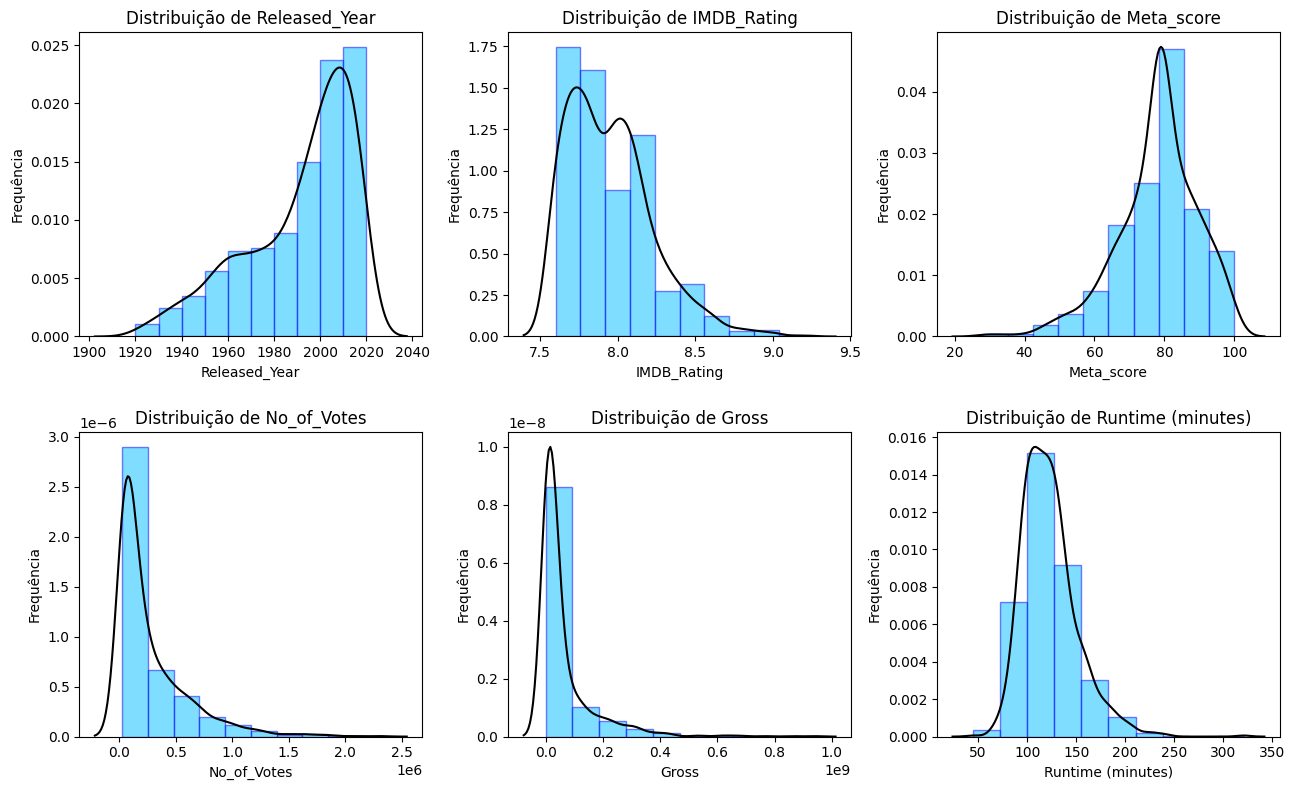

In [21]:
#separando os atributos numéricos para verificar a distribuição
numericos = df[["Released_Year", "IMDB_Rating", "Meta_score", "No_of_Votes", "Gross", "Runtime (minutes)"]]

#plotando histogramas de cada atributo numérico:
plt.figure(figsize=(13, 8))
for i, atributo in enumerate(numericos, 1):
    plt.subplot(2,3, i)
    plt.hist(data = df, x = atributo, color="deepskyblue", histtype="bar", rwidth=2, edgecolor="blue", density=True, alpha=0.5)
    sns.kdeplot(df[atributo], color="black")
    plt.title(f"Distribuição de {atributo}", fontsize=12)
    plt.xlabel(atributo)
    plt.ylabel("Frequência")
plt.tight_layout()
plt.savefig('Figura 02.png')
plt.show()

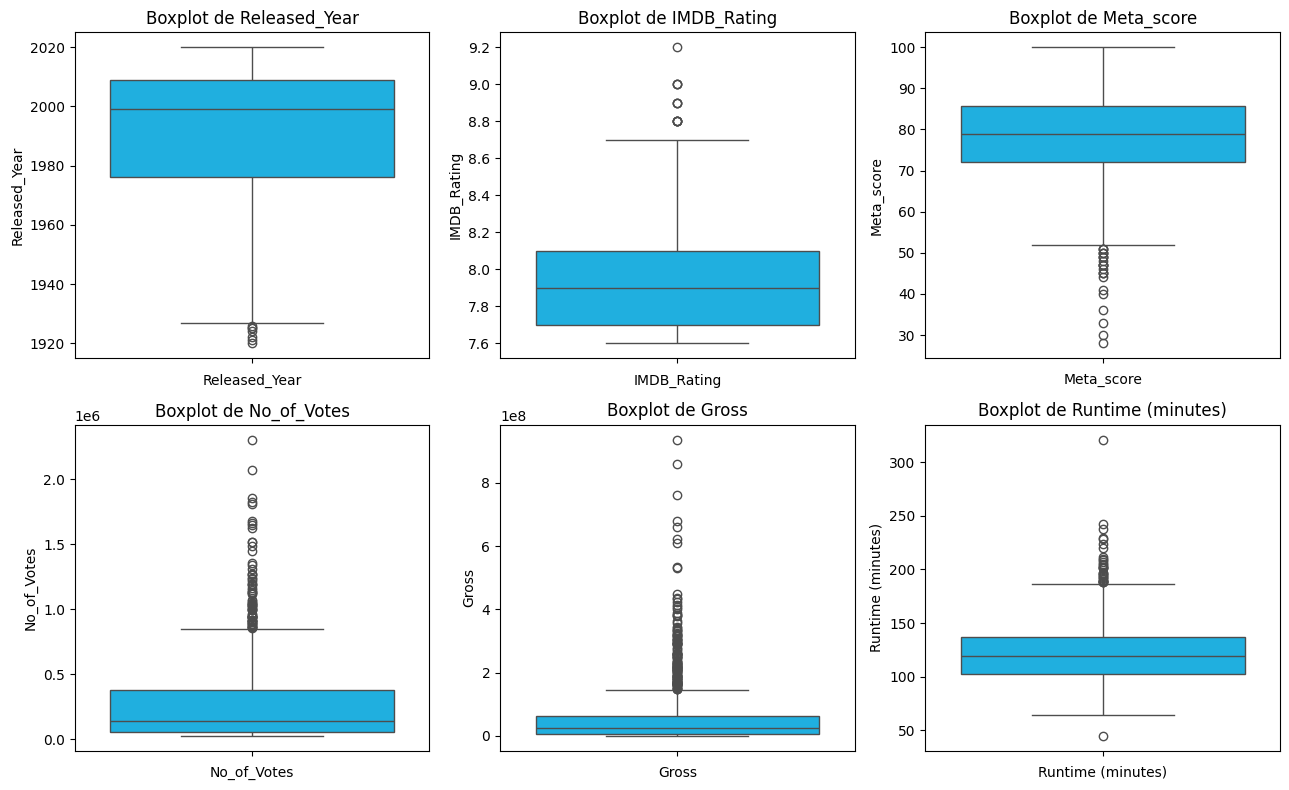

In [22]:
#plotando boxplots para cada atributo numérico:
plt.figure(figsize=(13,8))
for atributo in numericos:
    plt.subplot(2,3, numericos.columns.get_loc(atributo)+1)
    sns.boxplot(df[atributo], color="deepskyblue")
    plt.title(f"Boxplot de {atributo}")
    plt.xlabel(atributo)
plt.tight_layout()
plt.show()

Observando os gráficos, percebe-se que todas os atributos numéricos possuem uma distribuição assimétrica. A distribuição da nota do IMDB é distorcida à direita, indicando que a maioria dos filmes possui nota entre 7.5 e 8.0, com poucos filmes variando em 9.0. A distribuição dos anos de lançamento é distorcida à esquerda, indicando que a maioria dos filmes são recentes, sendo lançados entre 2000 e 2020. A distribuição da duração dos filmes indica que a maioria deles têm entre 100 e 150 minutos.

In [23]:
#função para plotar o gráficos de distribuição de frequencia de um atributo categórico:
def plotar_freq(data, atributo):
    plt.figure(figsize=(10,5))
    ax = sns.countplot(x=data, hue=data, palette="pastel", order=data.value_counts().index)
    plt.title(f"Distribuição de frequência de {atributo}", fontsize=14, pad=15)
    plt.xticks(rotation=45, ha="right")
    for p in ax.patches:
        contagem = p.get_height()
        ax.annotate(f'{contagem}', xy=(p.get_x() + p.get_width() / 2, contagem), xytext=(0, 5), textcoords="offset points", ha="center", va="bottom", fontsize=10)
    plt.tight_layout()
    plt.show()

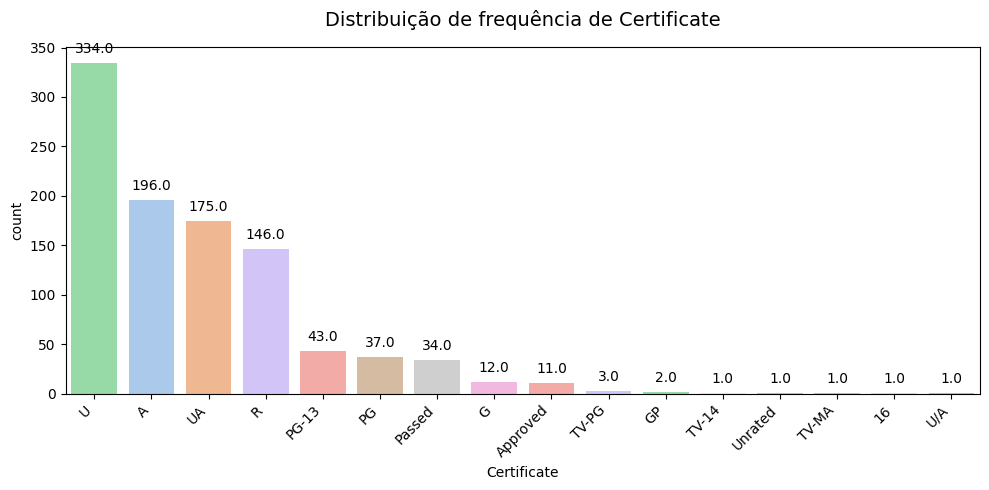

In [24]:
plotar_freq(df["Certificate"], "Certificate")

O gráfico indica que a maioria dos filmes tem classificação "U", referente à "Livre para todos os públicos".

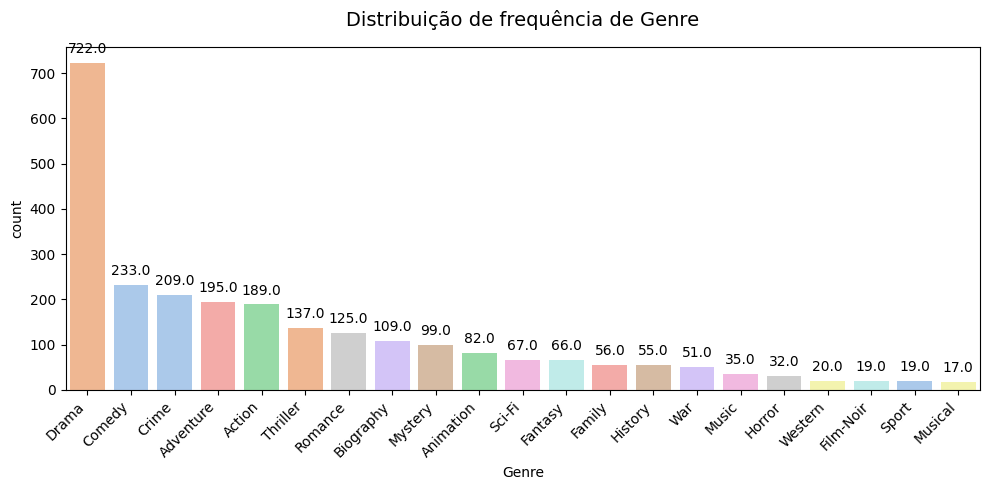

In [25]:
df_generos = df["Genre"].explode()
freq_generos = pd.DataFrame({'Frequência': df_generos.value_counts(),'Percentual': (df_generos.value_counts()*100/len(df)).map('{:.2f}%'.format)})

plotar_freq(df_generos, "Genre")

Observa-se que os 5 gêneros mais frequentes presente nos filmes são: Drama, Comédia, Crime, Aventura e Ação.

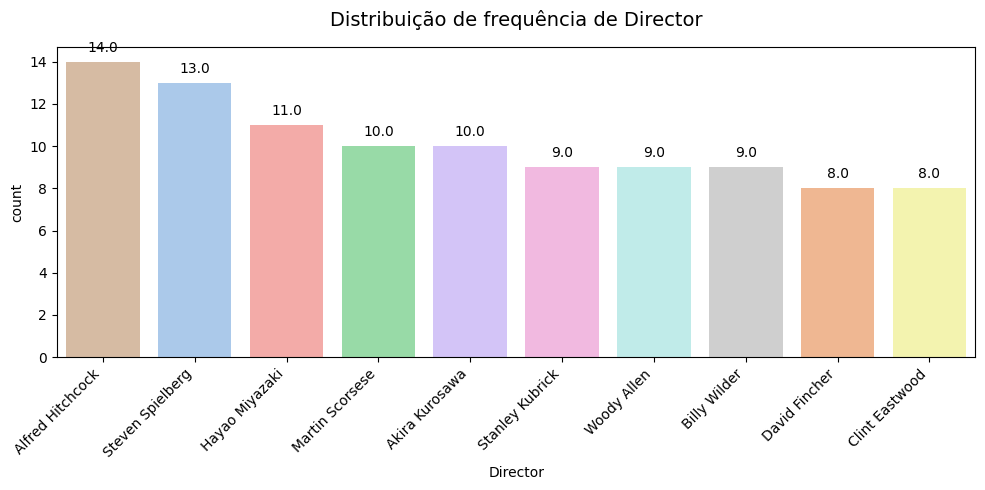

In [26]:
top_diretores = df["Director"].value_counts().head(10).index
df_diretores = df[df["Director"].isin(top_diretores)]
plotar_freq(df_diretores["Director"], "Director")

Alfred Hitchcock é o diretor mais frequente, tendo dirigido 14 filmes da base.

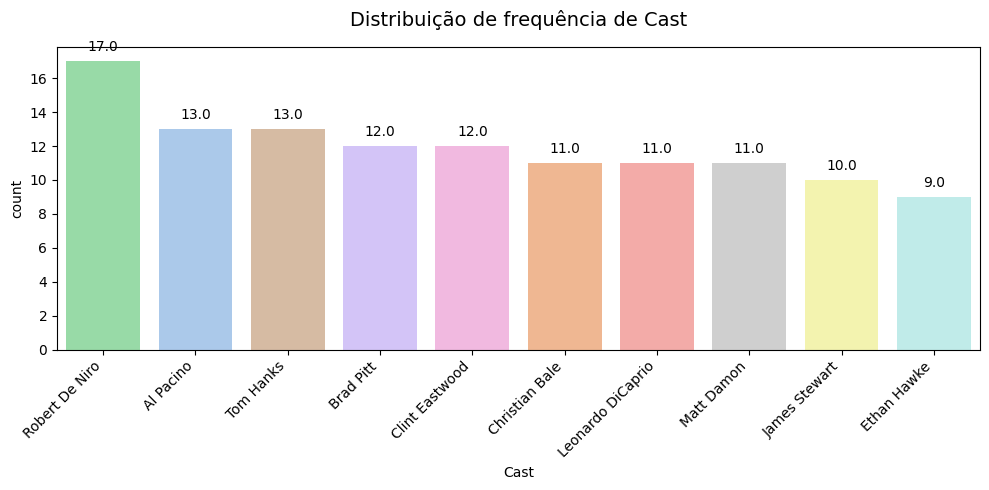

In [27]:
df_elenco = df.copy()
df_elenco["Cast"] = df_elenco["Cast"].str.split(",")
df_elenco = df_elenco.explode("Cast")
df_elenco["Cast"] = df_elenco["Cast"].str.strip()
elenco_top = df_elenco["Cast"].value_counts().head(10).index
df_elenco_top = df_elenco[df_elenco["Cast"].isin(elenco_top)]

plotar_freq(df_elenco_top["Cast"], "Cast")

Roberto de Niro, AI Pacino e Tom Hanks são os atores mais frequentes no elenco dos filmes.

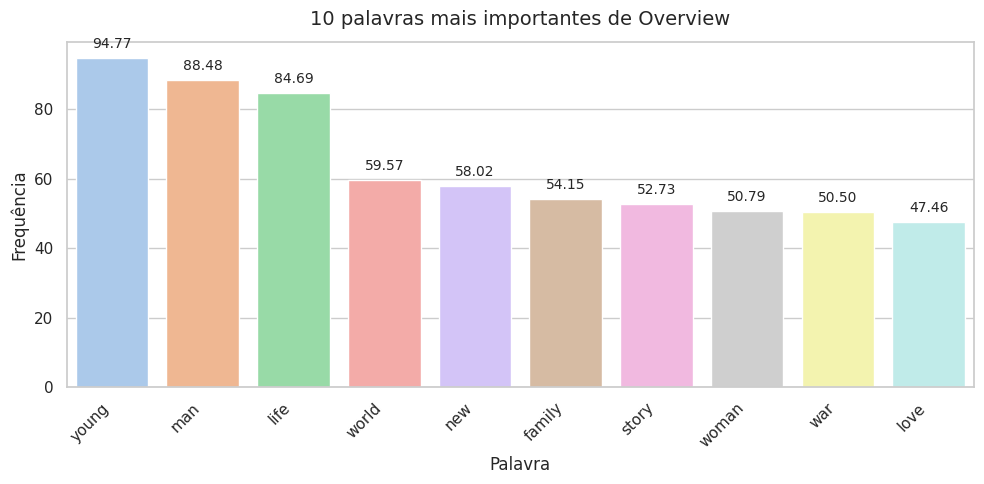

In [28]:
sns.set(style="whitegrid", palette="pastel")
palavras_importancia = df_palavras_rel.sum().sort_values(ascending=False)
df_palavras = palavras_importancia.reset_index()
df_palavras.columns = ["Palavra", "Frequência"]
plt.figure(figsize=(10,5))
ax = sns.barplot(data=df_palavras, hue="Palavra", x="Palavra", y="Frequência", palette="pastel")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', xy=(p.get_x() + p.get_width() / 2, p.get_height()), xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=10)
plt.title("10 palavras mais importantes de Overview", fontsize=14, pad=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Observando o gráfico de frequência da importância das palavras, temos que "young", "man" e "life" são as palavras de maior importância na sinopse dos filmes.

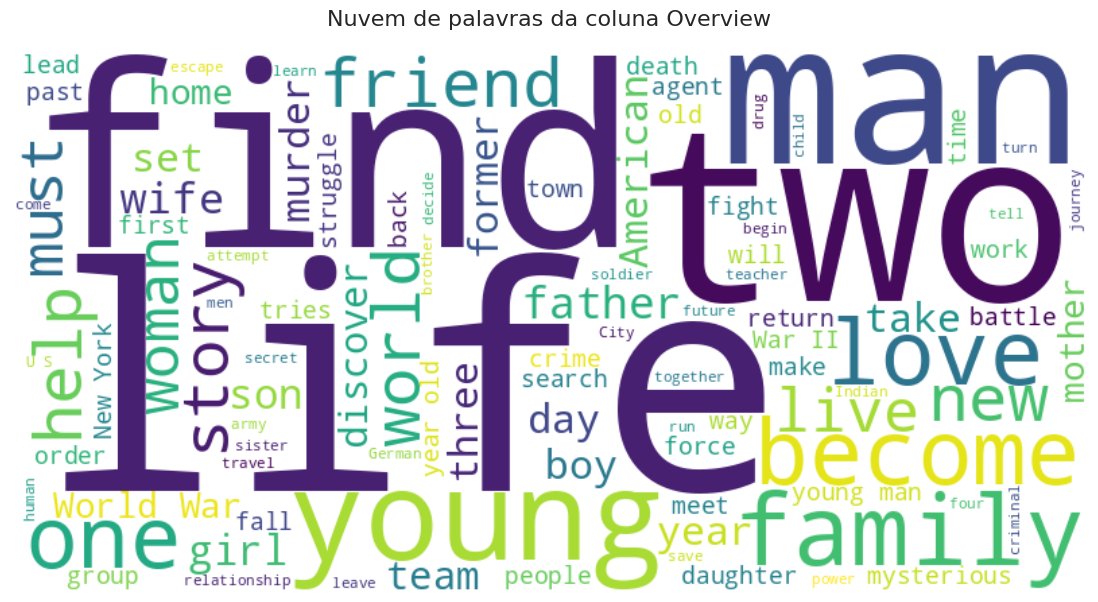

In [29]:
#concatenando as sinopses
text = " ".join(df['Overview'].dropna().astype(str))

#gerando o gráfico
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis", max_words=100, random_state=42).generate(text)
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuvem de palavras da coluna Overview", fontsize=16, pad=20)
plt.show()

A nuvem de palavras mostra que as palavras mais frequentes nas sinopses dos filmes são "life", "find", "two" e "man". Observando os dois últimos gráficos,eles podem indicar uma recorrência de filmes centrados em protagonistas jovens, muitas vezes do sexo masculino, e em temas universais ligados à vida e à experiência humana.

Fazendo uma análise por gênero, é possível fazer nuvens das palavras mais comuns nos filmes de um gênero específico. Foram plotadas 3 nuvens de palavras para os gêneros mais frequentes na base de dados: Drama, Comédia e Crime.

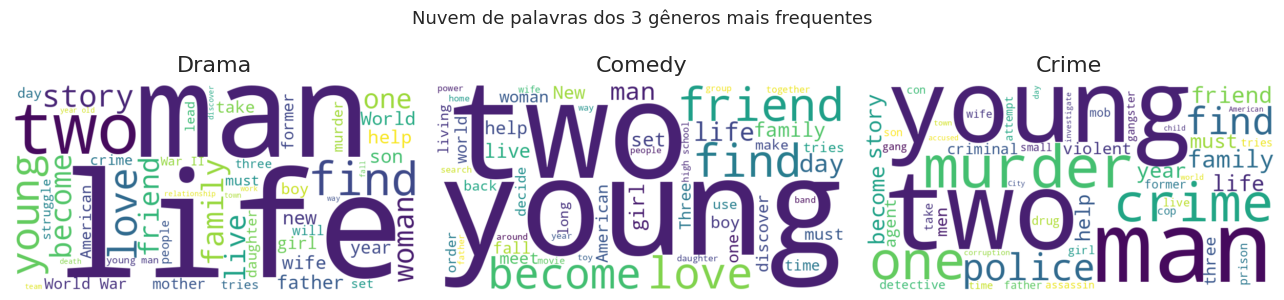

In [30]:
#removendo os gêneros das listas e classificando-os por frequência na base de dados:
df_gen = df.copy()
df_gen['Genre'] = df_gen['Genre'].apply(lambda x: x if isinstance(x, list) else [x])
df_gen = df_gen.explode('Genre')

top3_generos = df_gen['Genre'].value_counts().head(3).index

fig, axes = plt.subplots(1, 3, figsize=(13, 8))
for ax, genero in zip(axes, top3_generos):
    text = " ".join(df_gen[df_gen['Genre'] == genero]['Overview'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis", max_words=50, stopwords=None, random_state=42).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"{genero}", fontsize=16, pad=10)
plt.suptitle("Nuvem de palavras dos 3 gêneros mais frequentes", fontsize=13, y=0.70)
plt.tight_layout()
plt.show()

In [31]:
#agrupando as palavras mais importantes por gênero
df_gen_palavras = pd.concat([df_gen[["Genre"]].reset_index(drop=True), df_palavras_rel.reset_index(drop=True)], axis=1)
media_palavras = df_gen_palavras.groupby("Genre").mean()
#selecionando a palavra mais importante por gênero
mais_importantes = media_palavras.idxmax(axis=1)
mais_importantes

,0
Genre,
Action,young
Adventure,world
Animation,story
Biography,young
Comedy,man
Crime,man
Drama,young
Family,young
Fantasy,love


Observando as nuvens de palavras, é possível ver que as palavras "man" e "life" são mais comuns na descrição de filmes de drama, enquanto as palavras "two" e "young" são mais comuns em filmes de comédia e crime. Além disso, foi selecionada a palavra mais importante para a sinopse dos filmes de um gênero específico com base na vetorização que foi feita anteriormente. Essas características indicam que é possível encontrar padrões de palavras em um gênero específico, trazendo a possibilidade de inferir o gênero de um filme pela sua descrição.

Tendo feito uma análise univariada (atributo por atributo), agora é relevante realizar uma análise bivariada (comparando dois atributos por vez).

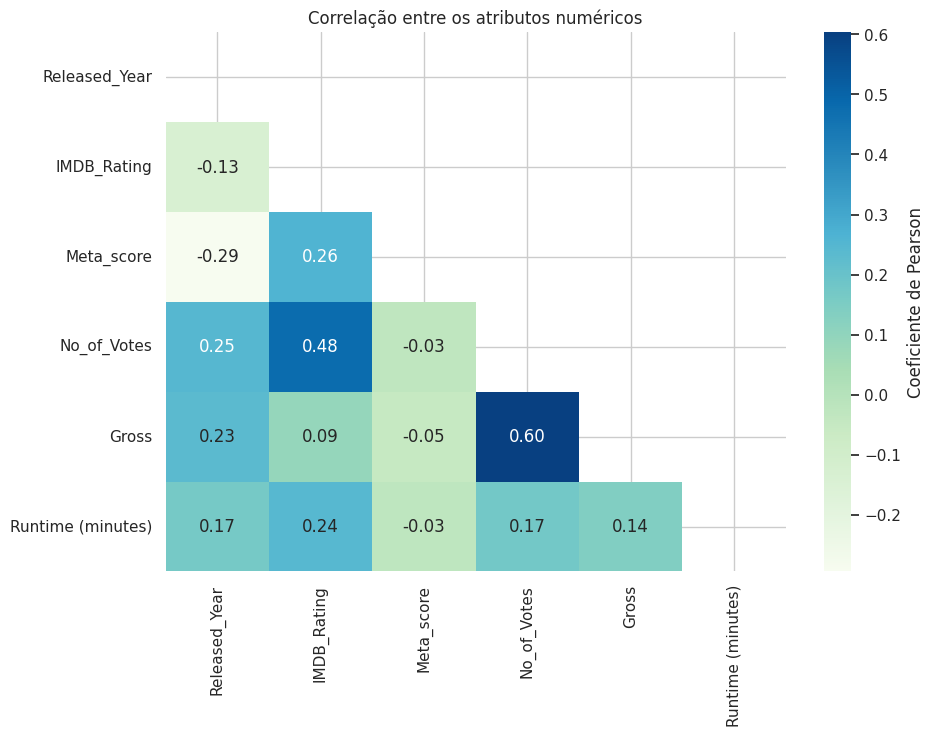

In [32]:
#calculando o índice de correlação de pearson entre os atributos numéricos:
correlacoes = numericos.corr(method="pearson")
#para mostrar apenas a matriz triangular inferior
filtro = np.triu(np.ones_like(correlacoes, dtype=bool))
plt.figure(figsize=[10,7])
sns.heatmap(data=correlacoes, mask=filtro, cmap="GnBu", fmt=".2f", cbar_kws={"label": "Coeficiente de Pearson"}, annot=True)
plt.title('Correlação entre os atributos numéricos')
plt.show()

Observando a matriz de correlação acima, é perceptível que o número de votos de um filme é consideravelmente correlacionado com o seu faturamento, ou seja, filmes que arrecadam mais tendem a receber mais votos, logo, sendo melhor avaliados. O número de votos também é relacionado de forma moderada com a sua nota do IMDB.

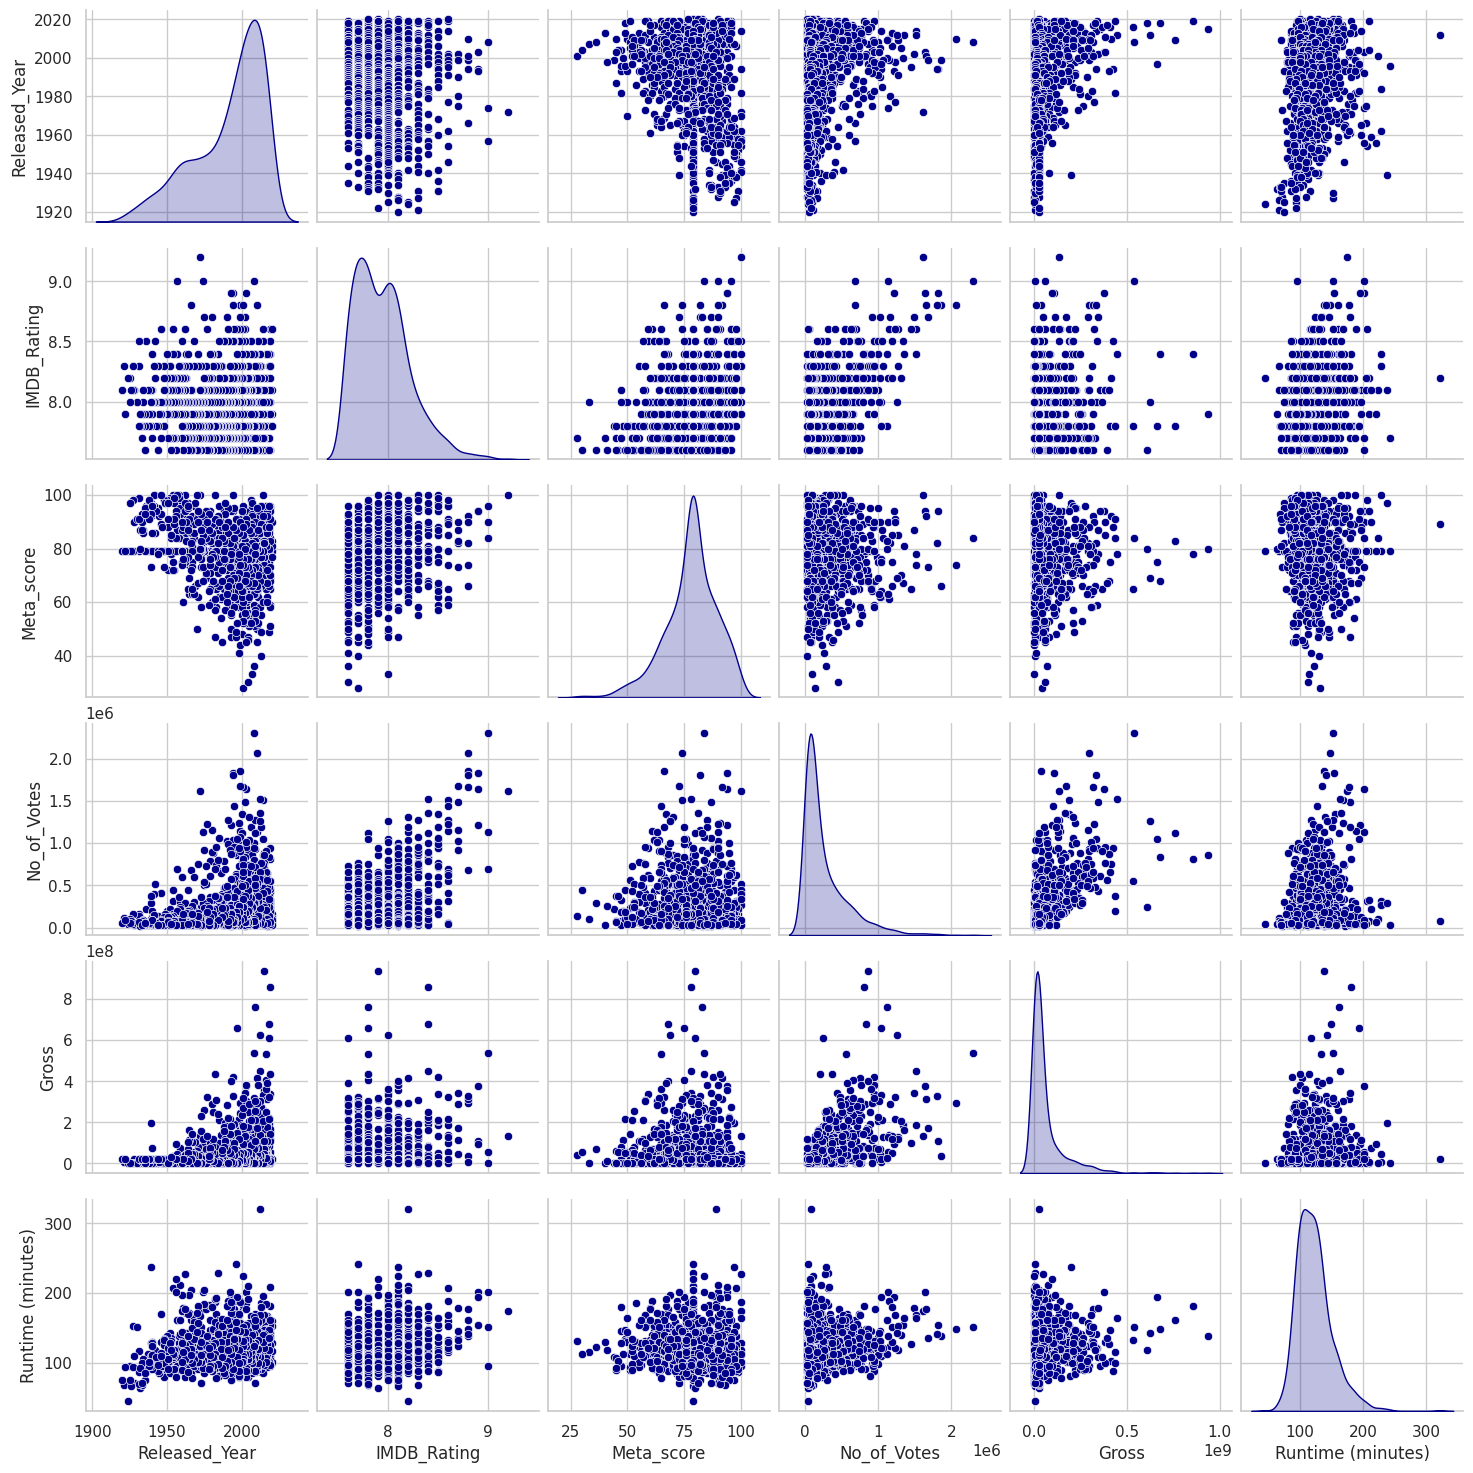

In [33]:
#plotando gráficos de dispersão para observar graficamente a correlação entre os atributos
sns.pairplot(numericos, kind="scatter", diag_kind="kde", plot_kws={"color": "darkblue"}, diag_kws={'color': "darkblue"})
plt.show()

Observando os gráficos. Apesar de uma correlação diferente das observadas na matriz de correlação não ser perceptível, tem-se uma visão mais clara da correlação entre o faturamento de um filme e sua nota do IMDB.

Sabendo dessas informações, a recomendação de um filme para uma pessoa desconhecida, sem conhecer suas preferências pessoais, se torna mais viável. Um critério válido é escolher um filme popular e com maior relevância para o publico(com a maior nota do IMDB ou com um número de votos considerável). Dessa forma, para obter o máximo de confiabilidade, é válido realizar uma análise inferencial. Será realizado um teste de hipótese sobre a média da nota IMDB de um filme para verificar se os filmes mais bem avaliados têm média de notas significativamente maior do que os demais. Isso será feito pelo teste t de Student para comparação de médias.

Hipótese nula: O top 10% dos filmes (mais bem avaliados) NÃO possuem notas IMDBs médias significativamente maiores que os demais. (médias são iguais)





In [34]:
#isolando o top 10% dos filmes
limiar = np.percentile(df["IMDB_Rating"], 90)
top_filmes = df[df["IMDB_Rating"] >= limiar]["IMDB_Rating"]
resto_filmes = df[df["IMDB_Rating"] < limiar]["IMDB_Rating"]
#teste t de Student para diferença de médias
t_stat, p_valor = stats.ttest_ind(top_filmes, resto_filmes, equal_var=False)
print(f"Média Top 10%: {top_filmes.mean():.2f}")
print(f"Média Resto: {resto_filmes.mean():.2f}")
print(f"p-valor:{p_valor}")

Média Top 10%: 8.46
Média Resto: 7.87
p-valor:5.821981017061501e-75


Como o p-valor < 0.05, pode-se rejeitar a hipótese nula de que as médias são iguais. Portanto, isso sustenta a hipótese de que a recomendação de filmes com maior nota IMDB, são mais seguros para agradar uma pessoa desconhecida. Entretanto, outro atributo relevante é o número de votos. É mais provável que filmes populares sejam mais bem vistos por pessoas desconhecidas. Nesse caso, é relevante considerar esse atributo também. O que será calculado será uma nota ponderada com base no número de votos de um filme e na sua nota IMDB, tendo essa última um peso maior, por maior confiabilidade como observado no teste t de Student.

In [35]:
#definição da nota de recomendação: taxa da nota IMDB com peso 2 + taxa do número de votos
df["Taxa_IMDB"] = (df["IMDB_Rating"] - df["IMDB_Rating"].min()) / (df["IMDB_Rating"].max() - df["IMDB_Rating"].min())
df["Taxa_Votos"] = (df["No_of_Votes"] - df["No_of_Votes"].min()) / (df["No_of_Votes"].max() - df["No_of_Votes"].min())
df["Nota_Recomendacao"] = 2*df["Taxa_IMDB"] + df["Taxa_Votos"]
#seleção do melhor filme para recomendar
melhor_filme = df.loc[df["Nota_Recomendacao"].idxmax(), ["Series_Title", "IMDB_Rating", "No_of_Votes"]]
print("Filme recomendado:\n", melhor_filme)

Filme recomendado:
 Series_Title    The Dark Knight
IMDB_Rating                 9.0
No_of_Votes             2303232
Name: 1, dtype: object


Dessa forma, com base na avaliação e na popularidade, o melhor filme para recomendar a uma pessoa desconhecida é "The Dark Night" ("Batman O Cavaleiro das Trevas").

Para identificar os principais fatores que estão relacionados com alta
expectativa de faturamento de um filme, é possível verificar quais variáveis se relacionam significativamente com o faturamento. Para isso, pode-se calcular a correlação de Pearson entre o faturamento e os outros atributos numéricos.

In [36]:
correlacoes_faturamento = numericos.corr()["Gross"].sort_values(ascending=False)
correlacoes_faturamento

,Gross
Gross,1.000000
No_of_Votes,0.603091
Released_Year,0.232659
Runtime (minutes),0.138057
IMDB_Rating,0.089700
Meta_score,-0.051787


Para identificar a relação com os atributos categóricos, pode-se realizar o teste ANOVA (análise de variância) sobre eles. Os melhores atributos para essa análise são o gênero e a classificação indicativa, pois são os que possuem menos classes. O objetivo é verificar se a média do faturamento difere significativamente entre as categorias gênero e classificação indicativa.

H0: As médias do faturamento entre as categorias de gênero são iguais.

In [37]:
df_anova = df[["Genre", "Certificate", "Gross"]].copy()
df_anova["Genre"] = df_anova["Genre"].apply(lambda x: x if isinstance(x, list) else [x])
df_anova = df_anova.explode("Genre")

modelo_gen = ols("Gross ~ C(Genre)", data=df_anova).fit()
anova_gen = sm.stats.anova_lm(modelo_gen, typ=2)
anova_gen

,sum_sq,df,F,PR(>F)
C(Genre),3.460732e+18,20.0,17.433305,1.732284e-57
Residual,2.497289e+19,2516.0,NaN,NaN


In [38]:
modelo_cert = ols("Gross ~ C(Certificate)", data=df_anova).fit()
anova_cert = sm.stats.anova_lm(modelo_cert, typ=2)
anova_cert

,sum_sq,df,F,PR(>F)
C(Certificate),3.109592e+18,15.0,20.637265,1.813788e-53
Residual,2.532403e+19,2521.0,NaN,NaN


Como o p-valor é menor que 0.05 para ambas as categorias Gênero e Classificação Indicativa, rejeita-se a hipótese nula e podemos afirmar que são fatores importantes que influenciam a expectativa de faturamento. No gráfico abaixo, pode-se observar a diferença das médias do faturamento em cada categoria em ambos os atributos:

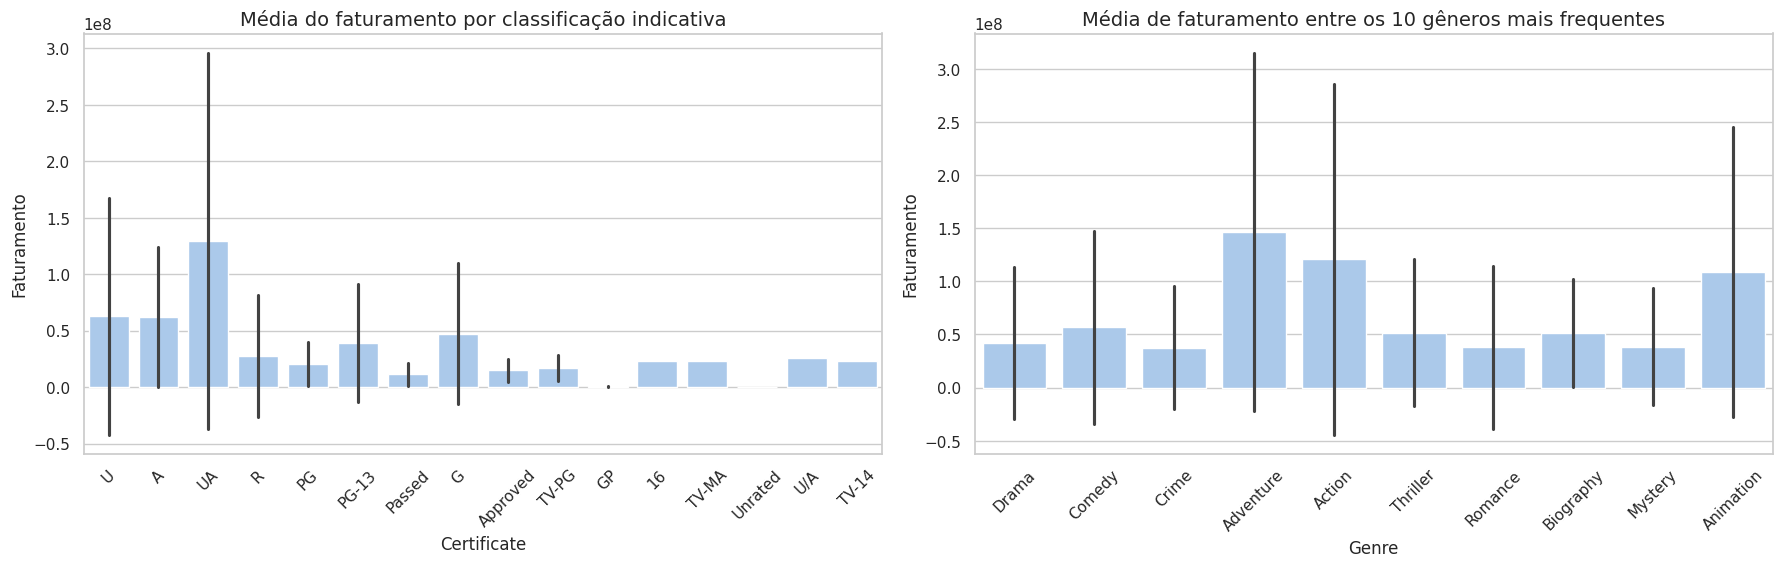

In [39]:
sns.set(style="whitegrid", palette="pastel")
fig, axes = plt.subplots(1, 2, figsize=(18,6))
#gráfico das medias do faturamento entre as classificações
sns.barplot(data=df_anova, x="Certificate", y="Gross", ax=axes[0], errorbar="sd", order=df_anova["Certificate"].value_counts().index)
axes[0].set_title("Média do faturamento por classificação indicativa", fontsize=14)
axes[0].set_ylabel("Faturamento")
axes[0].set_xlabel("Certificate")
axes[0].tick_params(axis='x', rotation=45)
#gráfico das medias do faturamento entre os 10 gêneros mais frequentes
top_genres = df_anova["Genre"].value_counts().head(10).index
sns.barplot(data=df_anova[df_anova["Genre"].isin(top_genres)], x="Genre", y="Gross", ax=axes[1], errorbar="sd", order=top_genres)
axes[1].set_title("Média de faturamento entre os 10 gêneros mais frequentes", fontsize=14)
axes[1].set_ylabel("Faturamento")
axes[1].set_xlabel("Genre")
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Portanto, como observado pela análise de correlação, os atributos: número de votos e ano de lançamento são os mais relacionados significativamente com o faturamento. Da mesma forma, o teste ANOVA indicou que o gênero e a classificação indicativa também influenciam significativamente a expectativa de faturamento. Assim, tanto o engajamento do público, quanto o ano de lançamento, tipo de filme e classificação indicativa estão entre os fatores mais relevantes. Uma observação interessante é que média ponderada de todas as críticas ("meta_score") possui uma correlação negativa com o faturamento. Uma possível razão para isso é a curiosidade que o público tem de conferir um filme que recebeu críticas negativas, ocasionando na popularidade das vendas de ingresso, aumentando o faturamento consequentemente.

# **5. MODELAGEM E VALIDAÇÃO**

Com os dados tratados, é importante definir quais atributos serão relevantes para cada modelo. Para o modelo preditor da nota do IMDB de um filme ANTES do seu lançamento, não é viável incluir as colunas "Gross" e "No_of_Votes", já que esses dados só existem após a estreia de um filme e incluí-los na base causaria vazamento de informações (data leakage). Para o modelo preditor da nota do IMDB de um filme APÓS o seu lançamento, todos os atributos podem ser considerados.

In [40]:
df_trabalho = df.copy()
df_trabalho.drop(columns=["Taxa_IMDB", "Taxa_Votos", "Nota_Recomendacao"], inplace=True)
df_trabalho.columns = [re.sub(r'[^a-zA-Z0-9_]', '_', col) for col in df_trabalho.columns]
df_trabalho

,Series_Title,Released_Year,Certificate,Genre,IMDB_Rating,Overview,Meta_score,Director,No_of_Votes,Gross,Runtime__minutes_,Cast
0,The Godfather,1972,A,"[Crime, Drama]",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,1620367,134966411.0,175,"Marlon Brando, Al Pacino, James Caan, Diane Ke..."
1,The Dark Knight,2008,UA,"[Action, Crime, Drama]",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,2303232,534858444.0,152,"Christian Bale, Heath Ledger, Aaron Eckhart, M..."
2,The Godfather: Part II,1974,A,"[Crime, Drama]",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,1129952,57300000.0,202,"Al Pacino, Robert De Niro, Robert Duvall, Dian..."
3,12 Angry Men,1957,U,"[Crime, Drama]",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,689845,4360000.0,96,"Henry Fonda, Lee J. Cobb, Martin Balsam, John ..."
4,The Lord of the Rings: The Return of the King,2003,U,"[Action, Adventure, Drama]",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,1642758,377845905.0,201,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or..."
...,...,...,...,...,...,...,...,...,...,...,...,...
994,Breakfast at Tiffany's,1961,A,"[Comedy, Drama, Romance]",7.6,A young New York socialite becomes interested ...,76.0,Blake Edwards,166544,23457439.5,115,"Audrey Hepburn, George Peppard, Patricia Neal,..."
995,Giant,1956,G,"[Drama, Western]",7.6,Sprawling epic covering the life of a Texas ca...,84.0,George Stevens,34075,23457439.5,201,"Elizabeth Taylor, Rock Hudson, James Dean, Car..."
996,From Here to Eternity,1953,Passed,"[Drama, Romance, War]",7.6,"In Hawaii in 1941, a private is cruelly punish...",85.0,Fred Zinnemann,43374,30500000.0,118,"Burt Lancaster, Montgomery Clift, Deborah Kerr..."
997,Lifeboat,1944,U,"[Drama, War]",7.6,Several survivors of a torpedoed merchant ship...,78.0,Alfred Hitchcock,26471,23457439.5,97,"Tallulah Bankhead, John Hodiak, Walter Slezak,..."


## **CENÁRIO 1: PREVISÃO DA NOTA IMDB DE UM FILME APÓS O SEU LANÇAMENTO**

Inicialmente, é necessário realizar o pré-processamento dos atributos preditores que serão utilizados no regressor. Os atributos numéricos "Released_Year", "Runtime (minutes)", "Meta_Score", "No_of_Votes" e "Gross" serão normalizados utilizando o StandardScaler. O atributo categórico"Certificate" será codificado utilizando One-Hot-Encoding e os atirbutos "Genre", "Cast" e "Director" serão codificados utilizando Multi-Label Encoding, pois possuem mais rótulos. Para simplificar o processamento, serão utilizados os 10 gêneros, atores e diretores mais frequentes. As 10 palavras mais importantes em frequência relativas obtidas anteriormente serão utilizadas como atributos no modelo também.

In [41]:
#pré-processamento de "certificate" utilizando one-hot-encoding
certificate_pp = pd.get_dummies(df_trabalho['Certificate'], prefix='Certificate')
#função auxiliar para processar strings multi-label (assumindo formato "label1, label2, label3")
def process_multi_label(column):
    return column.str.split(', ').fillna('')
#pré-processamento de genre, cast e director
df_trabalho["Genre"] = process_multi_label(df["Genre"])
df_trabalho["Cast"] = process_multi_label(df["Cast"])
df_trabalho["Director"] = process_multi_label(df["Director"])

#selecionando só os 10 generos mais frequentes
generos = [genero for sublist in df["Genre"] for genero in sublist]
top_generos = pd.Series(generos).value_counts().head(10).index.tolist()
#selecionado os 10 atores mais frequentes
atores = [actor for sublist in df["Cast"] for actor in sublist]
top_atores = pd.Series(atores).value_counts().head(10).index.tolist()
#selecionando os 10 diretores mais frequentes
diretores = [director for sublist in df["Director"] for director in sublist]
top_diretores = pd.Series(diretores).value_counts().head(10).index.tolist()

#binarizando os atributos multilabel
mlb_genre = MultiLabelBinarizer(classes=top_generos)
mlb_cast = MultiLabelBinarizer(classes=top_atores)
mlb_director = MultiLabelBinarizer(classes=top_diretores)
genre_codificado = mlb_genre.fit_transform(df["Genre"])
cast_codificado = mlb_cast.fit_transform(df["Cast"])
director_codificado = mlb_director.fit_transform(df["Director"])
#montando novos dataframes
genre_df = pd.DataFrame(genre_codificado, columns=[f'Genre_{g}' for g in top_generos])
cast_df = pd.DataFrame(cast_codificado, columns=[f'Cast_{a}' for a in top_atores])
director_df = pd.DataFrame(director_codificado, columns=[f'Director_{d}' for d in top_diretores])
numericos = ["Released_Year", "Runtime__minutes_", "Meta_score", "No_of_Votes", "Gross", "IMDB_Rating"]
numeric_df = df_trabalho[numericos]

#incorporando as 10 palavras mais importantes no dataframe
palavras_cols = [col for col in df_palavras_rel.columns if col != 'index']  # ajustar conforme necessário
palavras_df = df_palavras_rel[palavras_cols].reset_index(drop=True)

#dataframe pré-processado
df_processado = pd.concat([
    numeric_df.reset_index(drop=True),
    certificate_pp.reset_index(drop=True),
    genre_df.reset_index(drop=True),
    cast_df.reset_index(drop=True),
    director_df.reset_index(drop=True),
    palavras_df.reset_index(drop=True)
], axis=1)

df_processado

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Sci-Fi', 'Sport', 'War', 'Western'] will be ignored
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ["'", '-', '.', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'b', 'c', 'd', 'f', 'g', 'h', 'j', 'k', 'm', 'p', 'q', 's', 'u', 'v', 'w', 'x', 'y', 'z', 'Á', 'Ç', 'É', 'Ô', 'Ö', 'Ü', 'ß', 'à', 'á', 'ä', 'å', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'î', 'ï', 'ñ', 'ó', 'ô', 'ö', 'ø', 'ú', 'û', 'ü'] will be ignored
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ["'", '-', '.', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 

,Released_Year,Runtime__minutes_,Meta_score,No_of_Votes,Gross,IMDB_Rating,Certificate_16,Certificate_A,Certificate_Approved,Certificate_G,...,family,life,love,man,new,story,war,woman,world,young
0,1972,175,100.0,1620367,134966411.0,9.2,False,True,False,False,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,2008,152,84.0,2303232,534858444.0,9.0,False,False,False,False,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2,1974,202,90.0,1129952,57300000.0,9.0,False,True,False,False,...,0.607407,0.528722,0.0,0.000000,0.592883,0.0,0.000000,0.0,0.000000,0.000000
3,1957,96,96.0,689845,4360000.0,9.0,False,False,False,False,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,2003,201,94.0,1642758,377845905.0,8.9,False,False,False,False,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,1961,115,76.0,166544,23457439.5,7.6,False,True,False,False,...,0.000000,0.000000,0.0,0.404882,0.469739,0.0,0.000000,0.0,0.000000,0.784484
994,1956,201,84.0,34075,23457439.5,7.6,False,False,False,True,...,0.754272,0.656562,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
995,1953,118,85.0,43374,30500000.0,7.6,False,False,False,False,...,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
996,1944,97,78.0,26471,23457439.5,7.6,False,False,False,False,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.730628,0.0,0.682775,0.000000


In [42]:
#separando a variável a ser predita das variáveis preditoras:
y_cen1 = df_processado["IMDB_Rating"]
X_cen1 = df_processado.drop(columns=["IMDB_Rating"])

Como o objetivo é prever a nota IMDB que é um dado contínuo, o problema em questão é de regressão supervisionada. A metodologia utilizada será a escolha de 9 modelos candidatos de regressão, sendo 5 deles lineares: Regressão Linear, Ridge, Lasso e Elastic Net por serem mais simples e interpretáveis e 4 baseados em árvores: Decision Tree Regressor, Random Forest Regressor, Gradient Boosting Regressor, XGBoost e CatBoost Regressor para capturarem relações mais complexas. Os modelos serão treinados sem ajustes de hiperparâmetros e depois comparados utilizando métricas de regressão. Será utilizado K-Fold com 10 folds.



In [43]:
modelos = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(random_state=42),
    "Lasso": Lasso(random_state=42),
    "ElasticNet": ElasticNet(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": xgb.XGBRegressor(random_state=42, verbosity=0),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0)
}
#treinamento utilizando kfold com 10 folds
cv = KFold(n_splits=10, shuffle=True, random_state=42)
metricas = {"rmse": "neg_root_mean_squared_error","mae": "neg_mean_absolute_error","r2": "r2"}


resultados = []
#treinamento e avaliação dos modelos
for name, model in modelos.items():
    cv_res = cross_validate(model, X_cen1, y_cen1,
                            cv=cv,
                            scoring=metricas,
                            return_train_score=False,
                            n_jobs=-1,
                            verbose=0)

    #calculando médias e desvios do rmse e mae
    rmse_mean = -np.mean(cv_res["test_rmse"])
    rmse_std = np.std(-cv_res["test_rmse"])  # Inverter antes de calcular std

    mae_mean = -np.mean(cv_res["test_mae"])
    mae_std = np.std(-cv_res["test_mae"])  # Inverter antes de calcular std

    r2_mean = np.mean(cv_res["test_r2"])
    r2_std = np.std(cv_res["test_r2"])

    resultados.append({
        "model": name,
        "rmse_mean": rmse_mean,
        "rmse_std": rmse_std,
        "mae_mean": mae_mean,
        "mae_std": mae_std,
        "r2_mean": r2_mean,
        "r2_std": r2_std
    })

df_cv = pd.DataFrame(resultados).sort_values("rmse_mean")
df_cv

,model,rmse_mean,rmse_std,mae_mean,mae_std,r2_mean,r2_std
6,GradientBoosting,0.180501,0.010149,0.144467,0.007941,0.531308,0.106185
8,CatBoost,0.180914,0.013356,0.143699,0.008832,0.530530,0.103468
5,RandomForest,0.184347,0.011161,0.147628,0.007628,0.512512,0.101791
7,XGBoost,0.191396,0.009488,0.152953,0.007759,0.472397,0.118998
1,Ridge,0.202124,0.008575,0.160508,0.008163,0.413006,0.129046
0,Linear,0.202753,0.008964,0.161078,0.008019,0.409673,0.128515
3,ElasticNet,0.212550,0.011724,0.172400,0.010886,0.351094,0.145662
2,Lasso,0.222573,0.011546,0.182181,0.011884,0.288163,0.160752
4,DecisionTree,0.258449,0.018164,0.199385,0.018027,0.043158,0.214306


Observando os resultados, percebe-se que os modelos com melhor performance foram CatBoost, Random Forest e GradientBoosting.  XGBoost e Ridge tiveram um desempenho moderado para baixo. Os modelos lineares não obtiveram bons resultados. Com o intuito de ajustar os parâmetros desses 3 melhores modelos, será realizado RandomizedSearchCV considerando seu custo computacional menor.

In [ ]:
#melhores parâmetros para o catboost:
catboost_param_grid = {
    'iterations': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'random_strength': [0, 1, 2],
    'bagging_temperature': [0, 0.5, 1]
}

catboost_model = CatBoostRegressor(random_state=42, verbose=0)
catboost_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=catboost_param_grid,
    n_iter=30,
    scoring=metricas,
    refit='rmse',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
catboost_search.fit(X_cen1, y_cen1)
print(f"Melhores parâmetros CatBoost: {catboost_search.best_params_}")
print(f"Melhor RMSE: {catboost_search.best_score_:.4f}")

Fitting 10 folds for each of 30 candidates, totalling 300 fits
Melhores parâmetros CatBoost: {'random_strength': 2, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 4, 'bagging_temperature': 0.5}
Melhor RMSE: -0.1782


In [ ]:
#melhores parâmetros para o random forest:
rf_param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=50,
    scoring=metricas,
    refit='rmse',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_cen1, y_cen1)
print(f"Melhores parâmetros Random Forest: {rf_search.best_params_}")
print(f"Melhor RMSE: {-rf_search.best_score_:.4f}")

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
110 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/util

Melhores parâmetros Random Forest: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Melhor RMSE: 0.2058


In [ ]:
#melhores parâmetros para o xgboost:
xgb_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5, 2]
}

xgb_model = xgb.XGBRegressor(random_state=42, verbosity=0)
xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=50,
    scoring=metricas,
    refit='rmse',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_cen1, y_cen1)

print(f"Melhores parâmetros XGBoost: {xgb_search.best_params_}")
print(f"Melhor RMSE: {xgb_search.best_score_:.4f}")

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Melhores parâmetros XGBoost: {'subsample': 0.9, 'reg_lambda': 1.5, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.8}
Melhor RMSE: -0.1818


In [ ]:
#melhores parâmetros para o gradient boost:
gb_param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2']
}
gb_model = GradientBoostingRegressor(random_state=42)
gb_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=gb_param_grid,
    n_iter=50,
    scoring=metricas,
    refit='rmse',
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

gb_search.fit(X_cen1, y_cen1)
print(f"Melhores parâmetros Gradient Boosting: {gb_search.best_params_}")
print(f"Melhor RMSE: {gb_search.best_score_:.4f}")

Fitting 10 folds for each of 50 candidates, totalling 500 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
110 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
110 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/util

Melhores parâmetros Gradient Boosting: {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.05}
Melhor RMSE: -0.1877


Tendo os melhores parâmetros obtidos pelo RandomSearchCV, os 4 melhores modelos serão treinados e avaliados novamente utilizando KFold com 10 folds para confirmar se os ganhos são reais após o ajuste.

In [44]:
#melhores parâmetros obtidos:
melhores_params_cat = {'random_strength': 2, 'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 4, 'bagging_temperature': 0.5}
melhores_params_rf = {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
melhores_params_gb = {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 3, 'learning_rate': 0.1}
melhores_params_xgb = {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.5, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 1.0}

In [45]:
melhores_modelos = {
    "CatBoost": CatBoostRegressor(**melhores_params_cat, verbose=0, random_state=42),
    "RandomForest": RandomForestRegressor(**melhores_params_rf, random_state=42),
    "GradientBoost": GradientBoostingRegressor(**melhores_params_gb, random_state=42),
    "XGBoost": xgb.XGBRegressor(**melhores_params_xgb, random_state=42),
}
metricas = {"rmse": "neg_root_mean_squared_error","mae": "neg_mean_absolute_error","r2": "r2"}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

#treinando os modelos novamente e verificando os resultados:
resultados_pos_ajuste = []
for nome, modelo in melhores_modelos.items():
    cv_resultados = cross_validate(modelo, X_cen1, y_cen1, cv=kf, scoring=metricas, return_train_score=False)
    resultados_pos_ajuste.append({"modelo": nome,"rmse_medio": -np.mean(cv_resultados["test_rmse"]),"rmse_std": np.std(-cv_resultados["test_rmse"]),"mae_medio": -np.mean(cv_resultados["test_mae"]),"r2_medio": np.mean(cv_resultados["test_r2"])})

resultados_df = pd.DataFrame(resultados_pos_ajuste).sort_values(by="rmse_medio")
display(resultados_df[["modelo","rmse_medio","rmse_std","mae_medio","r2_medio"]])

,modelo,rmse_medio,rmse_std,mae_medio,r2_medio
0,CatBoost,0.178152,0.010505,0.142144,0.542110
2,GradientBoost,0.187885,0.011375,0.150517,0.494186
3,XGBoost,0.191541,0.011633,0.154769,0.475676
1,RandomForest,0.205821,0.012507,0.167204,0.399947


Observando os resultados, pode-se notar que o CatBoost seguiu com a melhor performance e seus resultados não mudaram muito com os novos parâmetros. O modelo Random Forest, mesmo com os novos parâmetros ainda teve o pior desempenho. Finalmente, os modelos serão combinados através do método Stacking para agregar no desempenho das predições. O metamodelo simples escolhido será o Ridge devido ao controle de overfitting da sua regularização L2 e maior estabilidade numérica.

In [46]:
#utilização do método stacking para combinar os 4 melhores modelos a fim de otimizar o resultado previsto
melhores_modelos_lista = [
    ("CatBoost", CatBoostRegressor(**melhores_params_cat, verbose=0, random_state=42)),
    ("XGBoost", xgb.XGBRegressor(**melhores_params_xgb, random_state=42)),
    ("GradientBoost", GradientBoostingRegressor(**melhores_params_gb, random_state=42))
]
meta_modelo = Ridge(alpha=1.0, random_state=42)
stacking_reg = StackingRegressor(estimators=melhores_modelos_lista, final_estimator=meta_modelo)
stacking_reg.fit(X_cen1, y_cen1)

StackingRegressor(estimators=[('CatBoost',
                               <catboost.core.CatBoostRegressor object at 0x7d24c21b1e50>),
                              ('XGBoost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=N...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('GradientBoost',
                               GradientBoostingRegressor(max_features='sqrt',
                                                         min_samples_leaf=2,
                                                         n_estimators=300,
                                                         random_state=42))],
                  final_estimator=Ridge(random_state=42))

In [47]:
#salvando o modelo resultante
with open('stacking_reg.pkl', 'wb') as arquivo:
    pickle.dump(stacking_reg, arquivo)

In [ ]:
#carregando o modelo resultante
with open('stacking_reg.pkl', 'rb') as arquivo:
   stacking_reg = pickle.load(arquivo)

Finalmente, para testar o modelo resultante, serão feitas algumas predições com as notas IMDB já conhecidas. Também serão feitas predições com dados externos.

In [ ]:
#realizando as previsões com as notas já conhecidas
y_test_pred = stacking_reg.predict(X_cen1)

In [ ]:
y_test_pred[:10]

array([8.42720905, 8.4520124 , 8.36205524, 8.38556845, 8.25994896,
       8.31336444, 8.23735286, 8.18646272, 8.18996941, 8.21152825])

In [ ]:
#comparando os valores reais com os valores preditos:
comp_test = pd.DataFrame({"Titulo": df_trabalho["Series_Title"],"Valor Real": y_cen1, "Valor Previsto": y_test_pred}, index=X_cen1.index)
comp_test

,Titulo,Valor Real,Valor Previsto
0,The Godfather,9.2,8.427209
1,The Dark Knight,9.0,8.452012
2,The Godfather: Part II,9.0,8.362055
3,12 Angry Men,9.0,8.385568
4,The Lord of the Rings: The Return of the King,8.9,8.259949
...,...,...,...
993,A Hard Day's Night,7.6,7.853207
994,Breakfast at Tiffany's,7.6,7.713533
995,Giant,7.6,7.910589
996,From Here to Eternity,7.6,7.769472


Embora com uma margem de erro de aproximadamente 0.5-0.8, é notável que omodelo de stacking combinando CatBoost, XGBoost e Gradient Boosting obteve um bom desempenho na previsão das notas, visto que as previsões são consistentemente próximas dos valores reais. É relevante testar o modelo com dados de teste que não estão na base de dados, para isso, serão usados exemplos de novos filmes.

In [ ]:
novos_filmes = pd.DataFrame({
    'Series_Title': ['Parasite', 'Joker', 'La La Land', 'The Shape of Water'],
    'Released_Year': ['2019', '2019', '2016', '2017'],
    'Certificate': ['A', 'A', 'A', 'A'],
    'Runtime': ['132 min', '122 min', '128 min', '123 min'],
    'Genre': ['Comedy, Drama, Thriller', 'Crime, Drama, Thriller', 'Comedy, Drama, Music', 'Adventure, Drama, Fantasy'],
    'Overview': [
        'Greed and class discrimination threaten the newly formed symbiotic relationship between the wealthy Park family and the destitute Kim clan.',
        'In Gotham City, mentally troubled comedian Arthur Fleck is disregarded and mistreated by society. He then embarks on a downward spiral of revolution and bloody crime. This path brings him face-to-face with his alter-ego: the Joker.',
        'While navigating their careers in Los Angeles, a pianist and an actress fall in love while attempting to reconcile their aspirations for the future.',
        'At a top secret research facility in the 1960s, a lonely janitor forms a unique relationship with an amphibious creature that is being held in captivity.'
    ],
    'Meta_score': [96.0, 59.0, 94.0, 87.0],
    'Director': ['Bong Joon Ho', 'Todd Phillips', 'Damien Chazelle', 'Guillermo del Toro'],
    'Star1': ['Song Kang-ho', 'Joaquin Phoenix', 'Ryan Gosling', 'Sally Hawkins'],
    'Star2': ['Lee Sun-kyun', 'Robert De Niro', 'Emma Stone', 'Michael Shannon'],
    'Star3': ['Cho Yeo-jeong', 'Zazie Beetz', 'John Legend', 'Richard Jenkins'],
    'Star4': ['Choi Woo-shik', 'Frances Conroy', 'Rosemarie DeWitt', 'Octavia Spencer'],
    'No_of_Votes': [662000, 1100000, 535000, 417000],
    'Gross': ['53,369,749', '335,451,311', '151,101,803', '63,859,435']
})

#filme requisitado pelo cliente:
shawshank = pd.DataFrame({
    'Series_Title': ['The Shawshank Redemption'],
    'Released_Year': ['1994'],
    'Certificate': ['A'],
    'Runtime': ['142 min'],
    'Genre': ['Drama'],
    'Overview': ['Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.'],
    'Meta_score': [80.0],
    'Director': ['Frank Darabont'],
    'Star1': ['Tim Robbins'],
    'Star2': ['Morgan Freeman'],
    'Star3': ['Bob Gunton'],
    'Star4': ['William Sadler'],
    'No_of_Votes': [2343110],
    'Gross': ['28,341,469']
})

#combinando os novos filmes em um dataframe:
filmes_teste = pd.concat([shawshank, novos_filmes], ignore_index=True)

#pré-processando novamente:
filmes_teste = filmes_teste.rename(columns=lambda x: x.strip().replace(" ", "_").replace("(", "").replace(")", "_").replace("-", "_"))
certificate_pp_teste = pd.get_dummies(filmes_teste['Certificate'], prefix='Certificate')

def process_multi_label(column):
    return column.str.split(', ').fillna('')

filmes_teste["Runtime__minutes_"] = filmes_teste["Runtime"].str.replace(" min", "").astype("int64")
filmes_teste = filmes_teste.drop(columns=["Runtime"])

filmes_teste["Gross"] = filmes_teste["Gross"].astype(str).str.replace(',', '')
filmes_teste["Gross"] = filmes_teste["Gross"].replace('', np.nan)
filmes_teste["Gross"] = filmes_teste["Gross"].astype("float64")

filmes_teste["Genre"] = process_multi_label(filmes_teste["Genre"])

filmes_teste["Cast"] = filmes_teste[["Star1", "Star2", "Star3", "Star4"]].astype(str).agg(', '.join, axis=1)
filmes_teste = filmes_teste.drop(columns=["Star1", "Star2", "Star3", "Star4"])

filmes_teste["Director"] = process_multi_label(filmes_teste["Director"])

genre_codificado_teste = mlb_genre.transform(filmes_teste["Genre"])
cast_codificado_teste = mlb_cast.transform(filmes_teste["Cast"])
director_codificado_teste = mlb_director.transform(filmes_teste["Director"])

genre_df_teste = pd.DataFrame(genre_codificado_teste, columns=[f'Genre_{g}' for g in mlb_genre.classes_])
cast_df_teste = pd.DataFrame(cast_codificado_teste, columns=[f'Cast_{a}' for a in mlb_cast.classes_])
director_df_teste = pd.DataFrame(director_codificado_teste, columns=[f'Director_{d}' for d in mlb_director.classes_])

numericos = ["Released_Year", "Runtime__minutes_", "Meta_score", "No_of_Votes", "Gross"]
numeric_df_teste = filmes_teste[numericos]

palavras_cols = [col for col in df_palavras_rel.columns if col != 'index']
palavras_df_teste = pd.DataFrame(columns=palavras_cols)

#montando o dataframe final
df_processado_teste = pd.concat([
    numeric_df_teste.reset_index(drop=True),
    certificate_pp_teste.reset_index(drop=True),
    genre_df_teste.reset_index(drop=True),
    cast_df_teste.reset_index(drop=True),
    director_df_teste.reset_index(drop=True),
], axis=1)

#alinhando as colunas para não dar conflito no catboost
missing_cols = set(X_cen1.columns) - set(df_processado_teste.columns)
for c in missing_cols:
    df_processado_teste[c] = 0
df_processado_teste = df_processado_teste[X_cen1.columns]

for col in X_cen1.columns:
    if col in df_processado_teste.columns:
        df_processado_teste[col] = df_processado_teste[col].astype(X_cen1[col].dtype)

df_processado_teste.head()

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Fantasy', 'Music'] will be ignored
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['-', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'W', 'Y', 'Z', 'b', 'c', 'd', 'g', 'h', 'j', 'k', 'm', 'p', 'q', 's', 'u', 'v', 'w', 'x', 'y', 'z'] will be ignored
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['Bong Joon Ho', 'Damien Chazelle', 'Frank Darabont', 'Guillermo del Toro', 'Todd Phillips'] will be ignored
  warnings.warn(


,Released_Year,Runtime__minutes_,Meta_score,No_of_Votes,Gross,Certificate_16,Certificate_A,Certificate_Approved,Certificate_G,Certificate_GP,...,family,life,love,man,new,story,war,woman,world,young
0,1994,142,80.0,2343110,28341469.0,False,True,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019,132,96.0,662000,53369749.0,False,True,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019,122,59.0,1100000,335451311.0,False,True,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016,128,94.0,535000,151101803.0,False,True,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017,123,87.0,417000,63859435.0,False,True,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_cen1_teste = df_processado_teste[X_cen1.columns]
y_cen1_teste = stacking_reg.predict(X_cen1_teste)

In [ ]:
novas_pred = pd.DataFrame({'Título': filmes_teste["Series_Title"],
                           'Nota Prevista': y_cen1_teste})
novas_pred

,Título,Nota Prevista
0,The Shawshank Redemption,8.312107
1,Parasite,8.422018
2,Joker,8.281824
3,La La Land,7.881096
4,The Shape of Water,7.973118


Os resultados previstos pelo modelo são bem próximos das notas IMDB reais, indicando uma boa capacidade preditiva. O filme The Shawshank Redemption tem nota 9.3 e foi subestimado em mais de 1 ponto, o que sugere que o modelo tende a ser conservador em filmes com avaliações muito altas. Entretanto, o filme Parasite, com nota 8.6, Joker, com nota 8.4, La La Land, com nota 8.0 e The Shape of Water, com nota 7.3, tiveram previsões bem alinhadas com as notas reais, apresentando diferenças inferiores a 0.7. Isso demonstra que, apesar de certa limitação em capturar outliers de altíssimo desempenho, o modelo consegue manter previsões consistentes e próximas da realidade para a maioria dos casos.

##**CENÁRIO 2: PREVISÃO DA NOTA IMDB DE UM FILME ANTES DO SEU LANÇAMENTO**

Para essa abordagem, será feita a predição do desempenho de um filme antes do lançamento, quando o número de votos e o faturamente ainda são desconhecidos. Para isso, um novo modelo de pré-lançamento será treinado de forma similar ao primeiro cenário. Será utilizada a técnica de Stacking com os melhores modelos do primeiro cenário.

In [ ]:
#seleção dos atributos:
features_pre_lancamento = df_processado.drop(["No_of_Votes", "Gross"], axis=1)
X_cen2 = features_pre_lancamento.drop("IMDB_Rating", axis=1, errors="ignore")
y_cen2 = df_trabalho["IMDB_Rating"]

In [ ]:
#divisao em treino e teste:
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(
    X_cen2, y_cen2, test_size=0.2, random_state=42
)

cat = CatBoostRegressor(**melhores_params_cat, verbose=0, random_state=42)
xgb = xgb.XGBRegressor(**melhores_params_xgb, random_state=42)
gbr = GradientBoostingRegressor(**melhores_params_gb, random_state=42)

In [ ]:
#stacking e treinamento:
stacking_pre = StackingRegressor(
    estimators=[
        ("cat", cat),
        ("xgb", xgb),
        ("gbr", gbr)
    ],
    final_estimator=Ridge(),
    cv=5,
    n_jobs=-1
)
stacking_pre.fit(X_train_pre, y_train_pre)

StackingRegressor(cv=5,
                  estimators=[('cat',
                               <catboost.core.CatBoostRegressor object at 0x7af4241d1e80>),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1.0, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None,...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=3,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                              ('gbr',
                               GradientBoostingRegressor(max_features='sqrt',
                                                         min_samples_leaf=2,
                                                         n_estimators=300,
                                                         random_state=42))],
                  final_estimator=Ridge(), n_jobs=-1)

In [ ]:
#avaliação
y_pred_pre = stacking_pre.predict(X_test_pre)
print("MAE Pré-lançamento:", mean_absolute_error(y_test_pre, y_pred_pre))
print("R² Pré-lançamento:", r2_score(y_test_pre, y_pred_pre))

MAE Pré-lançamento: 0.19436127455460742
R² Pré-lançamento: 0.1402232593978604


In [ ]:
X_cen2_teste = df_processado_teste[X_cen2.columns]
y_cen2_teste = stacking_pre.predict(X_cen2_teste)
y_cen2_teste

array([7.99220289, 8.213681  , 8.00940991, 7.99163881, 7.91783365])

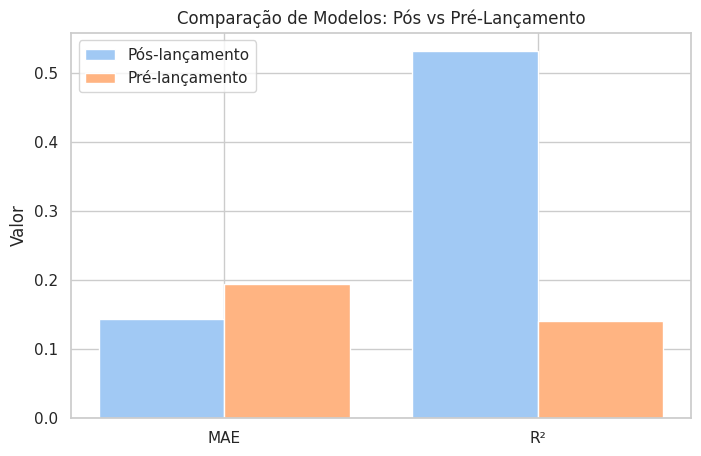

Desempenho Pós-lançamento:
MAE: 0.144, R²: 0.532

Desempenho Pré-lançamento:
MAE: 0.194, R²: 0.140


In [ ]:
#avaliação pós-lançamento
y_pred_pos = stacking_reg.predict(X_cen1)
mae_pos = mean_absolute_error(y_cen1, y_pred_pos)
r2_pos = r2_score(y_cen1, y_pred_pos)

#avaliação pré-lançamento
y_pred_pre = stacking_pre.predict(X_test_pre)  # modelo treinado sem No_of_Votes e Gross
mae_pre = mean_absolute_error(y_test_pre, y_pred_pre)
r2_pre = r2_score(y_test_pre, y_pred_pre)

metrics = ["MAE", "R²"]
pos_values = [mae_pos, r2_pos]
pre_values = [mae_pre, r2_pre]

x = range(len(metrics))
plt.figure(figsize=(8,5))
plt.bar(x, pos_values, width=0.4, label="Pós-lançamento", align="center")
plt.bar([i + 0.4 for i in x], pre_values, width=0.4, label="Pré-lançamento", align="center")

plt.xticks([i + 0.2 for i in x], metrics)
plt.ylabel("Valor")
plt.title("Comparação de Modelos: Pós vs Pré-Lançamento")
plt.legend()
plt.show()

# Impressão dos valores
print("Desempenho Pós-lançamento:")
print(f"MAE: {mae_pos:.3f}, R²: {r2_pos:.3f}\n")

print("Desempenho Pré-lançamento:")
print(f"MAE: {mae_pre:.3f}, R²: {r2_pre:.3f}")

Os resultados evidenciam uma diferença marcante entre os dois cenários avaliados: enquanto o modelo pós-lançamento apresentou desempenho aceitável, o modelo pré-lançamento obteve métricas bem inferiores, indicando baixa capacidade preditiva quando variáveis cruciais como número de votos e bilheteria ainda não estão disponíveis. Apesar de não ter alcançado o resultado esperado no contexto pré-lançamento, o projeto abre espaço para melhorias futuras, como o uso de técnicas mais avançadas de NLP para sinopses ou variáveis externas que possam enriquecer as previsões antes da estreia de um filme.

#**6. CONCLUSÃO**

O projeto seguiu de forma estruturada todas as etapas do ciclo CRISP-DM, começando pelo entendimento do negócio, que definiu como objetivo prever as notas de filmes no IMDb para apoiar análises pré e pós-lançamento. Em seguida, o entendimento dos dados permitiu mapear as variáveis mais relevantes, como gênero, elenco, direção, certificação e atributos numéricos. Na etapa de preparação, os dados foram tratados com as técnicas one-hot encoding, binarização de variáveis multilabel e seleção de palavras-chave, resultando em um conjunto consistente para modelagem. A fase de modelagem testou diferentes algoritmos, culminando na construção de um modelo de stacking com CatBoost, XGBoost e Gradient Boosting, que apresentou excelente desempenho no cenário pós-lançamento. Foi observado tanto o sucesso nesse caso quanto as limitações em predições pré-lançamento, reforçando a importância de dados adicionais. Por fim, a fase de implantação foi simulada com novos exemplos, demonstrando a aplicabilidade do modelo. Assim, o ciclo CRISP-DM foi concluído de forma prática, deixando espaço para avanços futuros, sobretudo na predição de filmes ainda não lançados.